# Introduction
  
Nous travaillons sur la base de données ~diabetes~ de python. La base initiale comporte $n = 442$ patients et $p = 10$ covariables. La variable $Y$ à expliquer est un score correspondant à l’évolution de la maladie. Pour s’amuser, un robot malicieux a contaminé le jeu de données en y ajoutant 200 variables explicatives inappropriées. Ensuite, non-content d’avoir déjà perverti notre jeu de données, il a volontairement mélangé les variables entre elle de façon aléatoire. Bien entendu le robot a ensuite pris soin d’effacer toute trace de son acte crapuleux si bien que nous ne connaissons pas les variables pertinentes. La nouvelle base de données comporte $n = 442$ patients et $p = 210$ covariables, notés $X$. Saurez-vous déjouer les plans de ce robot farceur et retrouver les variables pertinentes ?

# Imports

In [2]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LassoCV, LinearRegression
from numpy.linalg import inv


# Helpers

In [58]:
# ajoute une colone de 1 a gauche de X_tild
def get_X(X_tild):
  X_tild = X_tild.tolist()
  X = [[1] +  X_tild[i] for i in range(0, len(X_tild))]
  return np.matrix(X)

# Y [numpy matrix] - vector to calculate arithmetic mean against
# Returns the arithmetic mean of Y
def get_mean(Y):
    return sum(Y) / len(Y)

# Helper to generate random number easily
def rand():
    return random.randint(0, dfX.shape[1] - 1)


# Chargement des données


In [59]:
def import_data():
    df = pd.read_csv('data_dm3.csv', delimiter=",", header=None)
    return df

df = import_data()
df.head()


,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


Séparons maintenant le variable à expliquer, c'est a dire la dernière colonne de notre dataframe. Les variables `dfX` et `dfY` seront les dataframes contenant la matrice de design et la variables à expliquer:


In [60]:
num_df_cols = df.shape[1] - 1
dfX = df.drop(num_df_cols, axis=1)
dfX.head()


,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.937546,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,0.940726,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,0.338998,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.733290,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,-0.714867,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853


In [61]:
dfY = df[num_df_cols]
dfY.head()


0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: 210, dtype: float64

# Question 1
  
*Importer la base de données ~data_dm3.csv~ disponible depuis le lien https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d’observations.*


In [62]:
print("Nombre de variable explicatives:", dfX.shape[1])
print("Numbre d'observations", dfX.shape[0])


Nombre de variable explicatives: 210
Numbre d'observations 442


# Question 2
  
*Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ? Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des autres). Commenter les graphiques obtenus.*

Analysons dans un premier temps les moyennes et variances des colonnes de `dfX` et `dfY`:


In [63]:
dfX.mean(axis=0)


0      7.535450e-19
1     -1.507090e-17
2      5.494599e-20
3     -7.284269e-18
4      8.288995e-18
5     -2.712762e-17
6      1.971776e-17
7      8.540177e-18
8      1.029845e-17
9      4.018907e-18
10    -1.444295e-17
11     3.717489e-17
12    -3.642134e-17
13    -1.124038e-17
14    -3.750456e-17
15    -4.511851e-17
16     2.461580e-17
17     9.293722e-18
18     2.662526e-17
19    -5.601351e-17
20    -3.067556e-17
21    -4.521270e-18
22     6.781905e-18
23    -4.056584e-17
24     1.004727e-18
25    -2.813235e-17
26    -3.540092e-17
27    -5.953006e-17
28    -4.533829e-17
29     3.064416e-17
           ...     
180   -3.767725e-18
181    3.843080e-17
182    4.018907e-18
183    6.380015e-17
184    1.795949e-17
185   -1.306145e-17
186    1.550053e-17
187    3.918434e-17
188    1.871304e-17
189    1.356381e-17
190   -2.737880e-17
191    2.210399e-17
192   -3.843080e-17
193    4.511851e-17
194   -6.530724e-18
195   -3.014180e-17
196    3.014180e-17
197   -2.888589e-17
198    7.887105e-17


In [64]:
dfX.var(axis=0)


0      1.002268
1      1.002268
2      1.002268
3      1.002268
4      1.002268
5      1.002268
6      1.002268
7      1.002268
8      1.002268
9      1.002268
10     1.002268
11     1.002268
12     1.002268
13     1.002268
14     1.002268
15     1.002268
16     1.002268
17     1.002268
18     1.002268
19     1.002268
20     1.002268
21     1.002268
22     1.002268
23     1.002268
24     1.002268
25     1.002268
26     1.002268
27     1.002268
28     1.002268
29     1.002268
         ...   
180    1.002268
181    1.002268
182    1.002268
183    1.002268
184    1.002268
185    1.002268
186    1.002268
187    1.002268
188    1.002268
189    1.002268
190    1.002268
191    1.002268
192    1.002268
193    1.002268
194    1.002268
195    1.002268
196    1.002268
197    1.002268
198    1.002268
199    1.002268
200    1.002268
201    1.002268
202    1.002268
203    1.002268
204    1.002268
205    1.002268
206    1.002268
207    1.002268
208    1.002268
209    1.002268
Length: 210, dtype: floa

Nous remarquons que les colonnes de la matrice de design sont centrées et de variance proche de 1 à moins du tiers de pourcent près. En effet, la variance est égale à 1.002268 et est constante d'une colonne à l'autre.

Ci-dessous, nous analysons que notre variable explicative n'est ni centrée, ni normalisé:



In [65]:
print("La variable explicative à une moyenne de :", dfY.mean(axis=0))
print("La variable explicative à une variance de :", dfY.var(axis=0))


La variable explicative à une moyenne de : 152.13348416289594
La variable explicative à une variance de : 5943.331347923785


Sélectionnons 4 colonnes au hasard à l'aide de `random.randint` et générons une "scatter matrix":


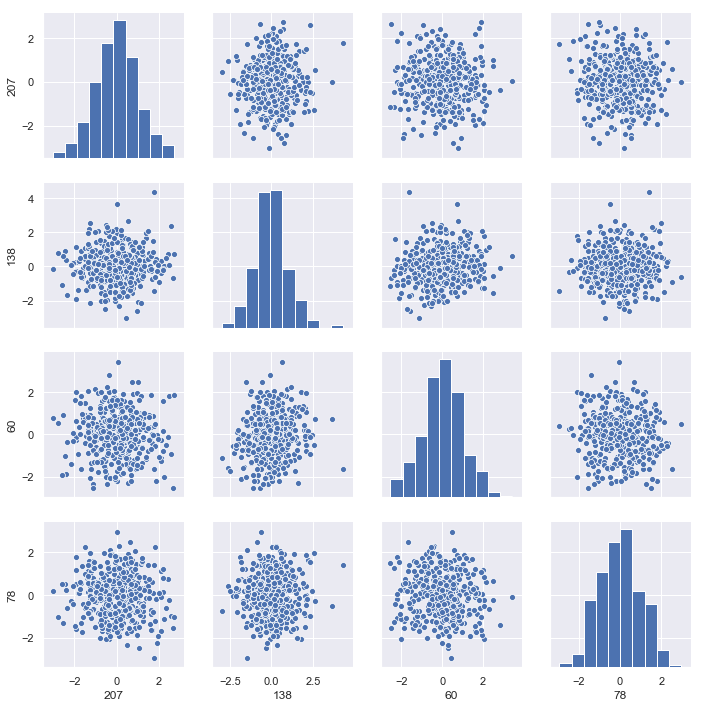

In [66]:
rand_cols = [rand() for i in range(4)]
sns_plot = sns.pairplot(dfX[rand_cols])

Nous remarquons sur la scatter matrix que les variables sélectionnée pour la réaliser ne sont pas corrélées puisqu'un nuage symétrique de points indique une corrélation de 0 entre les deux axes.

# Question 3
  
*Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle $X_{\mbox{train}}$, un pour tester le modèle X test. On mettra 20% de la base dans l’échantillon ’test’. Donner les tailles de chacun des 2 échantillons. On notera que le nouvel échantillon de covariables $X_{\mbox{train}}$ n’est pas normalizé. Dans la suite, on fera donc bien attention à inclure l’intercept dans nos régression.*




In [15]:
X = np.matrix(dfX)
Y = np.matrix(dfY).T

X_test = X[0:88,:]
X_train = X[87:-1,:]

Y_test = Y[0:88]
Y_train = Y[87:-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X test shape:", X_test.shape)
print("X train shape:", X_train.shape)
print("Y test shape:", Y_test.shape)
print("Y train shape:", Y_train.shape)


X test shape: (89, 210)
X train shape: (353, 210)
Y test shape: (89, 1)
Y train shape: (353, 1)


# Question 4
  
*Donner la matrice de covariance calculée sur $X_{\mbox{train}}$. Tracer le graphe de la décroissance des valeurs propres de la matrice de corrélation. Expliquer pourquoi il est légitime de ne garder que les premières variables de l’ACP. On gardera 60 variables dans la suite.*

La matrice des correlations est définie de la manière suivante:

$$Cor(X) = (X - \mathbb{E}(X))^T(X - \mathbb{E}(X))$$

Mais nous avons vu dans la question précédente que l'espérance de $X$ est nulle, donc notre matrice des correlations est égale à la matrice de Gram:

$$Cor(X) = X^TX$$.

Nous allons trouver les vecteurs propres de $X^TX$ à l'aide de la SVD. En effet, nous savons que pour une matrice $M \in \mathbb{R}^{n \times p}$

$$
M = USV^T
$$

Avec une matrice orthogonale $U \in \mathbb{R}^{n \times n}$, un matrice diagonale $S \in \mathbb{R}^{n \times p}$, et une matrice orthogonale $V \in \mathbb{R}^{p \times p}$, donc:

$$
X^TX = (USV^T)^T(USV^T)
= VS^TU^TUSV^T
= VS^TSV^T
$$

Ce qui veut bien dire qu'en prenant la matrice $V$ de la SVD de $X$, nous obtenons les vecteurs propres de notre matrice de corrélation $X^TX$:



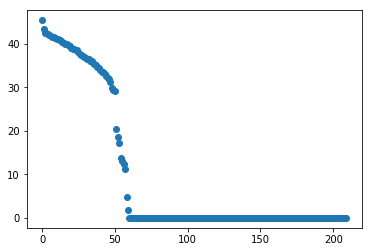

In [16]:
u, s, vh = np.linalg.svd(X_train)
plt.scatter(range(len(s)), s)

Nous voyons bien sur le graphique ci dessus que lorsque nous somme dans la base des vecteurs propres de $X^TX$, seulement 60 des valeurs propres de la matrice de corrélation ne sont pas nulles. C'est à dire que seulement 60 des colonnes de $X$ contiennent des informations affectées par la variations d'autre(s) colonne(s). Les autres colonnes ayant aucune influence sur nos 60 variables, nous pouvons donc les retirer de notre dataframe pour alléger les calculs suivants.

# Question 5
  
*Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui consiste à appliquer OLS avec $Y$ et $X_{\mbox{train}}V_{1:60}$, où $V_{1:60}$ contient les vecteurs propres (associé aux 60 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec intercept), puis tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de même avec la méthode des moindres carrés classique.*

## PCA before OLS


In [17]:
u, s, vh = np.linalg.svd(X_train)
Xpca = X_train@vh.T[:,0:60]
print("La taille de notre matrice de design après PCA est :", Xpca.shape)
theta_hat_pca_before_ols = LinearRegression(fit_intercept=True).fit(Xpca, Y_train)
print("Nos coefficients:")
print(theta_hat_pca_before_ols.coef_)


La taille de notre matrice de design après PCA est : (353, 60)
Nos coefficients:
[[-1.22330969e+01  2.17054945e+00 -2.03720914e+00 -5.40211814e+00
   2.35586394e+00 -7.76571081e-01  4.05826712e+00 -2.81099700e-01
  -1.77329602e+00 -3.44791089e+00  1.36056670e+00  5.43933482e-01
   1.35972761e+00  5.93832061e-01 -1.23802573e+00  4.24963156e+00
  -1.13911998e+00  5.89940047e-01  7.46534497e-01 -4.30535424e+00
  -6.60808712e-01  2.04583307e-01  1.03349261e-01  4.92049978e+00
   8.65639317e-01  2.38793662e+00  7.19228395e-04  4.24084737e-01
   2.69685873e+00 -2.89653858e+00  1.36145833e+00  2.11745233e+00
   2.49143991e+00 -2.27657513e+00  1.51113345e+00 -2.43503100e+00
  -1.34352655e+00 -2.24311197e+00  3.47332649e+00  3.19838747e+00
   1.19314296e-01 -3.40346223e+00  7.54369729e+00  3.36824649e+00
  -4.41704153e+00  5.12537594e+00 -2.51723512e+00 -6.67013764e+00
  -7.24569531e-01 -7.13199177e+00  7.79086660e+00 -9.72432611e+00
  -1.61102779e+01  2.24268297e+01 -3.06928158e-01  1.11193253

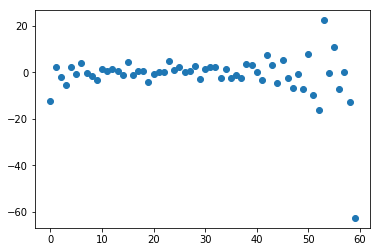

In [18]:
plt.scatter(range(theta_hat_pca_before_ols.coef_.shape[1]), theta_hat_pca_before_ols.coef_)


In [20]:
theta_hat_ols = LinearRegression(fit_intercept=True).fit(X_train, Y_train)
print("OLS intercept", theta_hat_ols.intercept_)
print("X_train shape", X_train.shape)


OLS intercept [152.84982516]
X_train shape (353, 210)


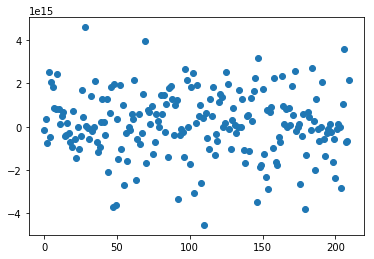

In [21]:
plt.scatter(range(theta_hat_ols.coef_.shape[1]), theta_hat_ols.coef_)


Nous remarquons quand sans réaliser de PCA avant OLS, nous obtenons des coefficients énormes, de l'ordre de $10^{15}$ pour les plus gros. Alors qu'avec un PCA before OLS, nos plus grands coefficients sont de l'ordre de 20-30.

# Question 6
  
*Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur moyenne de la variable $Y$ (sur le train set). Les intercepts des 2 questions sont-ils égaux ? Commenter. Uniquement pour cette question, centrer et réduire les variables après ACP (de petite dimension). Faire une régression avec ces variables et vérifier que l’intercept est bien égal à la moyenne de $Y$ sur le train.*



In [22]:
print("Intercept OLS:", theta_hat_ols.intercept_)
print("Intercept PCA before OLS:", theta_hat_pca_before_ols.intercept_)


Intercept OLS: [152.84982516]
Intercept PCA before OLS: [152.11138544]



Les deux intercepts ne sont donc pas égaux. Nous remarquons que l'intercept avec PCA before OLS est moins proche de la moyenne des $Y_{\mbox{train}}$ que ne l'est l'intercept pour OLS.

Centrons / réduisons maintenant $X_{\mbox{train}}$ et réalisons un PCA before OLS pour comparer la valeur de l'intercept de notre modèle avec la moyenne de $Y_{\mbox{train}}$.


In [24]:
Xpca_c = Xpca-Xpca.mean(axis=0)
Xpca_n = Xpca_c/np.sqrt(Xpca.var(axis=0))

q6_model = LinearRegression(fit_intercept=True).fit(Xpca_n, Y_train)
print("Intercept for OLS after normalizationn of PCA:", q6_model.intercept_)
print("Y_train mean:", Y_train.mean())


Intercept for OLS after normalizationn of PCA: [153.73654391]
Y_train mean: 153.73654390934846



Nous trouvons donc la même valeur (à 7 décimales près) entre notre intercept et la moyenne des $Y_{\mbox{train}}$.

# Question 7

*Pour les 2 méthodes (OLS et PCA before OLS) : Tracer les résidus de la prédiction sur l’échantillon test. Tracer leur densité (on pourra par exemple utiliser un histogramme). Calculer le coefficient de détermination sur l’échantillon test. Calculer le risque de prédiction sur l’échantillon test.*



Text(0.5, 0, 'Observations')

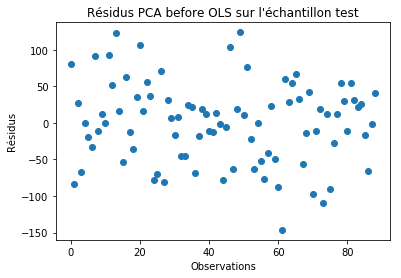

In [25]:
Y_pred_pca = theta_hat_pca_before_ols.predict(X_test@vh.T[:,:60])
res_pca = Y_test - Y_pred_pca

plt.scatter(range(len(res_pca)), [r[0] for r in res_pca])
plt.title("Résidus PCA before OLS sur l'échantillon test")
plt.ylabel("Résidus")
plt.xlabel("Observations")

Text(0.5, 0, 'Observations')

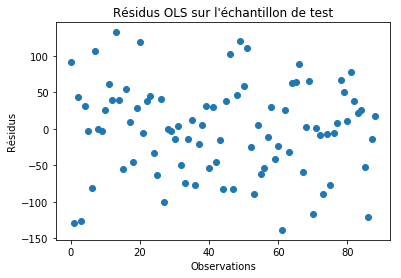

In [26]:
Y_pred_ols = theta_hat_ols.predict(X_test)
res_ols = Y_test - Y_pred_ols

plt.scatter(range(len(res_ols)), [r[0] for r in res_ols])
plt.title("Résidus OLS sur l'échantillon de test")
plt.ylabel("Résidus")
plt.xlabel("Observations")

Utilisons la librairie Seasborn à nouveau pour réaliser un histogramme de nos résidus pour OLS et PCA before OLS:



/home/thomas/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'OLS')

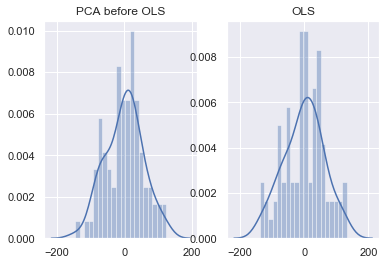

In [67]:
f, axes = plt.subplots(1, 2)


plt7c = sns.distplot(res_pca, bins=20, kde=True, ax=axes[0])
plt7c = sns.distplot(res_ols, bins=20, kde=True, ax=axes[1])
axes[0].set_title("PCA before OLS")
axes[1].set_title("OLS")

Enfin, nous calculons le coefficient de détermination sur l'échantillon de test à l'aide de scikit-learn ainsi que le risque de prédiction normalisée de la manière suivante:

$$
R_{\mbox{pred}} = \frac{||Y_{\mbox{pred}} - Y_{\mbox{test}}||^2}{n}
$$


In [68]:
print("R2 for PCA before OLS", theta_hat_pca_before_ols.score(X_test@vh.T[:,:60], Y_test))
print("R2 for OLS", theta_hat_ols.score(X_test, Y_test))

def get_R_pred(Y_test, Y_pred):
  A = Y_test - Y_pred
  return (A.T@A / len(Y_test))[0,0]

R_pred_pca_ols = get_R_pred(Y_test, Y_pred_pca)
R_pred_ols = get_R_pred(Y_test, Y_pred_ols)

print("R_pred PCA before OLS:", R_pred_pca_ols)
print("R_pred OLS:", R_pred_ols)


R2 for PCA before OLS 0.42767779780822845
R2 for OLS 0.29118125887098567
R_pred PCA before OLS: 3032.249876257207
R_pred OLS: 3755.4292526940235


# Question 8

*Coder la méthode de forward variable sélection. On pourra utiliser la statistique du test de nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arrêt sur la méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver la totalité des variables. Afficher l’ordre de sélection des variables.*



In [32]:
def get_p_value(t_stat, deg):
    # compute the p-value if t_stat follows a Student of degree deg
    p_val = (1 - stats.t.cdf(abs(t_stat), deg)) * 2
    return p_val

def fast_forward_selection(X_train, Y_train, stop=1000):
  p = X_train.shape[1]
  n = X_train.shape[0]
  res_prev = Y_train
  X = get_X(X_train)
  col_maxs = []
  pvalues = []
  tstats = []
  for i in range(p + 1):
    col_max = 0
    tstat_max = 0
    tstats_j = []

    for j in range(p + 1):
      if j not in col_maxs:
        X_j = X[:, j]
        model_j = LinearRegression(fit_intercept=False).fit(X_j, res_prev)
        X_j_bar = get_mean(X_j)
        Y_pred = model_j.predict(X_j)
        res_new = Y_train - Y_pred
        sigma_est = np.sqrt(1 / (n - 1) * (res_new.T@res_new)[0,0])
        tstat = abs(model_j.coef_[0,0]) / (sigma_est * np.sqrt(inv(X_j.T@X_j)[0,0])) 
        tstats_j.append(tstat)
        if tstat > tstat_max:
          col_max = j
          tstat_max = tstat

    pvalue = get_p_value(tstat_max, n - 1)
    if pvalue < stop:
      res_prev = res_new
      col_maxs.append(col_max)
      pvalues.append(pvalue)
      tstats.append(tstats_j)
    else:
      return [[c - 1 for c in col_maxs[1:]], pvalues, tstats]

  return [[c - 1 for c in col_maxs[1:]], pvalues, tstats]


In [38]:
result = fast_forward_selection(X_train, Y_train)
print("Ordre de selection des variables:", result[0])
print("pvalues", result[1])


Ordre de selection des variables: [58, 123, 167, 23, 34, 174, 99, 94, 7, 133, 103, 27, 115, 112, 17, 92, 121, 128, 162, 148, 197, 146, 79, 33, 110, 22, 45, 18, 19, 60, 182, 168, 43, 84, 86, 207, 158, 160, 44, 177, 53, 85, 81, 4, 138, 49, 159, 95, 11, 143, 188, 13, 116, 50, 136, 129, 183, 88, 147, 55, 142, 76, 29, 20, 178, 131, 208, 3, 47, 62, 9, 108, 195, 153, 35, 106, 149, 28, 72, 179, 16, 166, 75, 100, 169, 102, 5, 150, 161, 97, 191, 90, 175, 105, 61, 185, 109, 119, 114, 78, 74, 209, 65, 120, 186, 24, 172, 41, 91, 2, 77, 93, 176, 104, 130, 82, 152, 134, 59, 46, 139, 83, 66, 187, 101, 157, 87, 189, 141, 140, 192, 117, 193, 127, 54, 113, 51, 164, 171, 165, 36, 71, 107, 200, 180, 202, 68, 198, 89, 31, 14, 155, 201, 184, 80, 137, 132, 69, 64, 70, 42, 48, 154, 56, 145, 111, 206, 124, 32, 122, 126, 125, 37, 199, 63, 190, 39, 135, 15, 38, 204, 73, 25, 12, 118, 170, 196, 156, 163, 98, 30, 194, 6, 21, 144, 1, 96, 40, 57, 26, 8, 151, 0, 67, 203, 205, 173, 10, 181, 52]
pvalues [0.0, 4.594366220

# Question 9

*Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode en donnant:*

1. *les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme et 3eme variables (en abscisse : l’index des variables, en ordonné : la valeur des stats) ,*
2. *le graphe des 50 premières p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la ligne horizontale d’ordonnée 0.1. Enfin on donnera la liste des variables sélectionnées.*


In [39]:
result_trimmed = fast_forward_selection(X_train, Y_train, 0.1)
print("Variables selectionnees:", result_trimmed[0])
print("pvalues", result_trimmed[1])


Variables selectionnees: [58, 123, 167, 23, 34, 174, 99]
pvalues [0.0, 4.594366220800339e-09, 1.9448257604359753e-07, 2.230973249894852e-05, 6.161408358718035e-05, 0.00014767475703725275, 0.00027147789041803705, 0.028673792423168587]


## Première variable


Text(0, 0.5, 't-Stat')

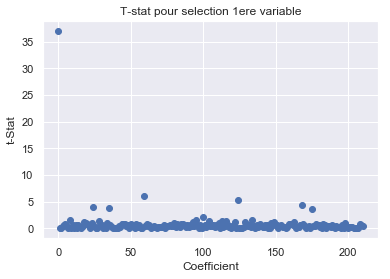

In [41]:
y = result_trimmed[2][0]
x = list(range(len(y)))

plt.scatter(x, y)
plt.title("T-stat pour selection 1ere variable")
plt.xlabel("Coefficient")
plt.ylabel("t-Stat")

## Seconde variable


Text(0, 0.5, 't-Stat')

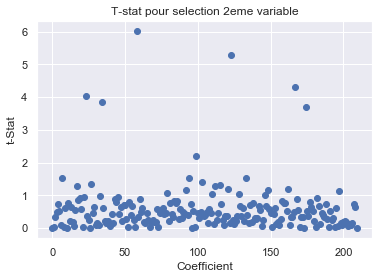

In [42]:
y = result_trimmed[2][1]
x = list(range(len(y)))

plt.scatter(x, y)
plt.title("T-stat pour selection 2eme variable")
plt.xlabel("Coefficient")
plt.ylabel("t-Stat")


## Troisième variable


Text(0, 0.5, 't-Stat')

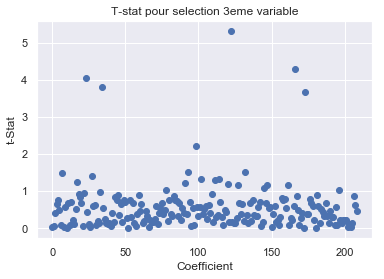

In [43]:
y = result_trimmed[2][2]
x = list(range(len(y)))

plt.scatter(x, y)
plt.title("T-stat pour selection 3eme variable")
plt.xlabel("Coefficient")
plt.ylabel("t-Stat")


Text(0, 0.5, 'p-value')

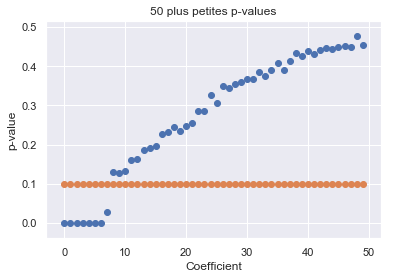

In [44]:
y = result[1][:50]
y_limit = [0.1 for i in y]
x = range(len(y))

plt.scatter(x, y)
plt.scatter(x, y_limit)
plt.title("50 plus petites p-values")
plt.xlabel("Coefficient")
plt.ylabel("p-value")


## Question 10

*Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu l’échantillon test et le comparer à ceux de OLS et PCA before OLS.*

In [45]:
print("Fast forward variable selection (number of selected columns)", result_trimmed[0])
X_train_ffs = X_train[:,result_trimmed[0]]
model_ffs_ols = LinearRegression(fit_intercept=True).fit(X_train_ffs, Y_train)
Y_pred_ffs = model_ffs_ols.predict(X_test[:,result_trimmed[0]])
print("R2 for fast forward selection OLS", model_ffs_ols.score(X_test[:,result_trimmed[0]], Y_test))
R_pred_ffs = get_R_pred(Y_test, Y_pred_ffs)
print("R_pred for fast forward selection OLS:", R_pred_ffs)
print("R_pred_fastForward < R_pred_ols ?", R_pred_ffs < R_pred_ols)
print("R_pred_fastForward < R_pred_pca_ols ?", R_pred_ffs < R_pred_pca_ols)


Fast forward variable selection (number of selected columns) [58, 123, 167, 23, 34, 174, 99]
R2 for fast forward selection OLS 0.4475310210603155
R_pred for fast forward selection OLS: 2927.0644867704714
R_pred_fastForward < R_pred_ols ? True
R_pred_fastForward < R_pred_pca_ols ? True



Nous trouvons donc un risque de prédiction plus petit avec le modèle Ridge qu'avec OLS ou PCA before OLS.

## Question 11
  
*Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées ”folds”) de façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque fold.*

In [46]:
kf = KFold(n_splits=4, random_state=10, shuffle=True)
_folds = kf.split(X_train)
folds = []

i = 0
for train_index, test_index in _folds:
  print("\n\nTRAIN", i, ":\n", train_index, "\nTEST", i, " :\n", test_index)
  folds.append([train_index, test_index])
  i += 1




TRAIN 0 :
 [  0   2   3   4   5   7   8   9  10  11  13  14  15  16  18  19  21  22
  23  28  30  31  32  33  35  36  37  38  39  40  41  42  44  45  46  48
  49  50  51  53  54  55  58  59  60  61  62  63  66  67  68  70  71  72
  73  74  75  77  79  81  82  83  84  85  86  89  90  91  93  94  95  96
  98  99 101 103 104 106 107 108 109 111 112 115 116 117 118 119 120 122
 123 124 125 127 128 129 131 132 133 134 135 136 137 140 141 143 144 145
 149 150 153 154 155 156 157 158 159 160 161 162 165 166 168 169 171 176
 177 178 179 180 182 184 185 186 187 188 190 191 192 193 194 195 196 198
 199 200 201 203 204 206 207 208 209 210 212 213 214 216 217 220 221 222
 223 224 226 228 230 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 248 249 250 251 252 253 254 255 256 258 259 260 261 262 263 265
 267 268 269 270 271 273 274 275 276 279 281 283 284 285 286 287 288 289
 290 291 292 293 294 295 297 298 299 300 302 304 305 306 307 308 309 311
 312 313 315 316 318 319 320 321 322 3

# Question 12

*Appliquer la méthode de la régression ridge. Pour le choix du paramètre de régularisation, on fera une validation croisée sur les ”folds” définies lors de la question précédente. A tour de rôle chacune des ”folds” servira pour calculer le risque de prédiction alors que les autres seront utilisées pour estimer le modèle. On moyennera ensuite les 4 risques de prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre de régularisation (on veillera à bien choisir l’espace de définition pour le graphe). Donner le paramètre de régularisation optimal et la valeur du risque sur le test.*




In [47]:
ridge_param_space = np.linspace(0, 100, 20)
def fit_ridge(X, Y, folds):
  R_pred_bars = []
  for alpha in ridge_param_space:
    R_preds = []
    for i_train, i_test in folds:
      clf = Ridge(alpha=alpha)
      clf.fit(X[i_train], Y[i_train])
      Y_pred = clf.predict(X[i_test])
      R_pred = get_R_pred(Y[i_test], Y_pred)
      R_preds.append(R_pred)

    R_pred_bar = np.mean(R_preds)
    R_pred_bars.append(R_pred_bar)
  return R_pred_bars

ridge_param_curve = fit_ridge(X_train, Y_train, folds)
print(ridge_param_curve)


[19725.057068212333, 3868.2429103202953, 3857.305752874005, 3847.401814139806, 3838.6896702631398, 3831.190810428525, 3824.84080763573, 3819.547978446685, 3815.215766700655, 3811.7513298983868, 3809.0687241961705, 3807.0898265696833, 3805.744275948606, 3804.968997146406, 3804.707567995887, 3804.9095525751727, 3805.529857829777, 3806.528138582898, 3807.8682597650263, 3809.517816662376]


Graphons maintenant notre courbe de paramètre Ridge:


[  0.           5.26315789  10.52631579  15.78947368  21.05263158
  26.31578947  31.57894737  36.84210526  42.10526316  47.36842105
  52.63157895  57.89473684  63.15789474  68.42105263  73.68421053
  78.94736842  84.21052632  89.47368421  94.73684211 100.        ]


Text(0, 0.5, 'Risque de prediciton')

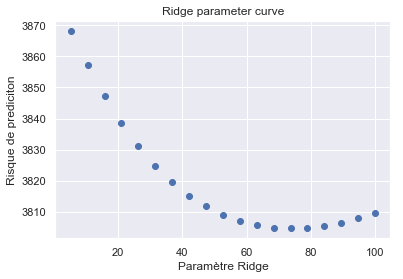

In [48]:
y = ridge_param_curve[:]
print(ridge_param_space)

ridge_param_space = list(np.linspace(0, 100, 20))
plt.scatter(ridge_param_space[1:], y[1:])
plt.title("Ridge parameter curve")
plt.xlabel("Paramètre Ridge")
plt.ylabel("Risque de prediciton")


Nous concluons donc que:


In [49]:
print("Le parametre Ridge optimal est:", ridge_param_space[np.argmin(ridge_param_curve)])
print("Et son risque est:", min(ridge_param_curve))


Le parametre Ridge optimal est: 73.6842105263158
Et son risque est: 3804.707567995887


# Question 13
   
*A l’aide de la fonction lassoCV de sklearn, choisir le paramètre de régularisation du LASSO. Donner le risque de prédiction associé.*



In [53]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_train, [y[0] for y in Y_train.tolist()])
Y_pred_lasso = lasso_model.predict(X_test)
R_pred_lasso = get_R_pred(Y_test, Y_pred_lasso)
print("Risque de prediction lasso: ", R_pred_lasso)


Risque de prediction lasso:  5389.933166498974


# Question 14
  
*Donner les variables selectionées par le lasso. Combien y-en a t-il ? Appliquer la méthode OLS aux variables sélectionnées. Cette méthode est appelé Least-square LASSO.*


In [55]:
# coefs = lasso_model.coef_
lasso_selected_cols = [i for i, c in enumerate(lasso_model.coef_) if c]
print("Le parametre Lasso optimal trouve est", lasso_model.alpha_)
print("Le lasso a selectionne les colonnes suivantes", lasso_selected_cols)


Le parametre Lasso optimal trouve est 6.631995961001097
Le lasso a selectionne les colonnes suivantes [13, 58, 123, 129, 167, 174]


In [56]:
model_ols_lasso = LinearRegression()
model_ols_lasso.fit(X_train[:,lasso_selected_cols], Y_train)
Y_pred_ols_lasso = model_ols_lasso.predict(X_test[:,lasso_selected_cols])
R_pred_ols_lasso = get_R_pred(Y_test, Y_pred_ols_lasso)
print("Le risque de prediciton de Least-square Lasso est ", R_pred_ols_lasso)


Le risque de prediciton de Least-square Lasso est  2806.624540445817


## Question 15

*Cette dernière question est un question d’ouverture vers une approche non-linéaire. En utilisant les variables sélectionnées par le LASSO (Q13) ou par la méthode forward (Q9), mettre au point une méthode de régression non-linéaire. On apprendra les différents paramètres par validation croisée et l’on donnera la valeur du risque de prédiction calculé sur l’échantillon test. Des performances moindres par rapport à OLS peuvent se produire. Commenter.*